Mounting Google Drive

In [2]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import sys
sys.path.insert(0,'/content/drive/MyDrive /Colab Notebooks/Session 7')

In [4]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torchvision

Updating Device to CUDA

In [7]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu") #c2

CUDA Available? True


Importing custom modules

In [8]:
import utils
import model

In [9]:
from utils import *

In [10]:
from model import *

Defining data tranformations

In [11]:
train_transforms = transforms.Compose([
    #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    #transforms.Resize((28, 28)),
    #transforms.RandomRotation((-10., 10.), fill=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


Downloading MNIST dataset and splitting to train and test set

In [12]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:12<00:00, 13288648.79it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [13]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Creating Data Loaders from train data and test data

In [14]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

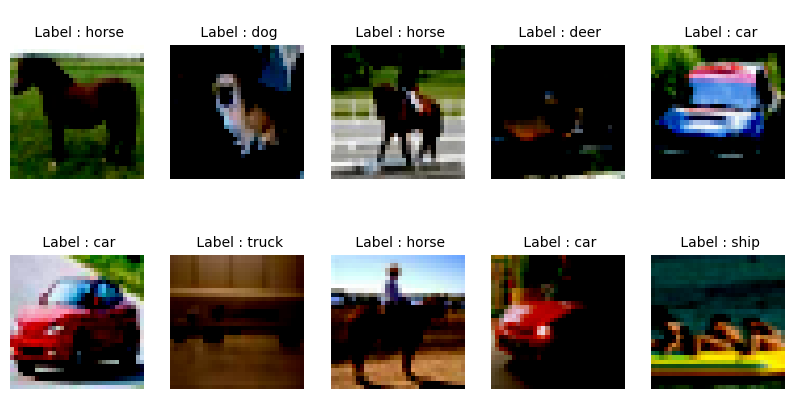

In [15]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
num_of_images = 10
fig = plt.figure(figsize=(10,5))

for index in range(1, num_of_images+1):
    ax = fig.add_subplot(2, 5, index)
    ax.axis('off')
    actual = classes[labels[index]]
    ax.set_title(f'\n Label : {actual}',fontsize=10)
    ax.imshow(np.transpose(images[index], (1, 2, 0)))

Transferring model to GPU and printing model summary

In [16]:
model1 = Net(norm='BN').to(device)
summary(model1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             160
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,440
             ReLU-12           [-1, 16, 16, 16]               0
      BatchNorm2d-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Training and evaluating the model with BatchNorm2d layers

In [18]:
model1 =  Net(norm="BN").to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.20, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.10)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model1, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model1, device, test_loader)

EPOCH: 1


Loss=1.2121105194091797 Batch_id=390 Accuracy=39.45: 100%|██████████| 391/391 [00:19<00:00, 20.50it/s]



Test set: Average loss: 1.6118, Accuracy: 4394/10000 (43.94%)

EPOCH: 2


Loss=1.1834187507629395 Batch_id=390 Accuracy=55.23: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]



Test set: Average loss: 1.2228, Accuracy: 5600/10000 (56.00%)

EPOCH: 3


Loss=0.9897438883781433 Batch_id=390 Accuracy=61.06: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]



Test set: Average loss: 1.0483, Accuracy: 6255/10000 (62.55%)

EPOCH: 4


Loss=0.9557163119316101 Batch_id=390 Accuracy=65.06: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]



Test set: Average loss: 1.0983, Accuracy: 6152/10000 (61.52%)

EPOCH: 5


Loss=0.8186842799186707 Batch_id=390 Accuracy=67.55: 100%|██████████| 391/391 [00:17<00:00, 21.75it/s]



Test set: Average loss: 0.9415, Accuracy: 6710/10000 (67.10%)

EPOCH: 6


Loss=0.75606369972229 Batch_id=390 Accuracy=69.70: 100%|██████████| 391/391 [00:18<00:00, 21.09it/s]



Test set: Average loss: 0.9616, Accuracy: 6720/10000 (67.20%)

EPOCH: 7


Loss=0.7760634422302246 Batch_id=390 Accuracy=71.30: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s]



Test set: Average loss: 0.8195, Accuracy: 7168/10000 (71.68%)

EPOCH: 8


Loss=0.9844141006469727 Batch_id=390 Accuracy=73.08: 100%|██████████| 391/391 [00:18<00:00, 21.71it/s]



Test set: Average loss: 0.8189, Accuracy: 7208/10000 (72.08%)

EPOCH: 9


Loss=0.5686725378036499 Batch_id=390 Accuracy=74.61: 100%|██████████| 391/391 [00:19<00:00, 20.43it/s]



Test set: Average loss: 0.7776, Accuracy: 7293/10000 (72.93%)

EPOCH: 10


Loss=0.32275697588920593 Batch_id=390 Accuracy=75.79: 100%|██████████| 391/391 [00:17<00:00, 21.82it/s]



Test set: Average loss: 0.8104, Accuracy: 7224/10000 (72.24%)

EPOCH: 11


Loss=0.762784481048584 Batch_id=390 Accuracy=76.32: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]



Test set: Average loss: 0.7649, Accuracy: 7366/10000 (73.66%)

EPOCH: 12


Loss=0.5743210911750793 Batch_id=390 Accuracy=77.39: 100%|██████████| 391/391 [00:19<00:00, 20.56it/s]



Test set: Average loss: 0.7601, Accuracy: 7407/10000 (74.07%)

EPOCH: 13


Loss=0.6687602400779724 Batch_id=390 Accuracy=78.04: 100%|██████████| 391/391 [00:17<00:00, 21.80it/s]



Test set: Average loss: 0.7534, Accuracy: 7429/10000 (74.29%)

EPOCH: 14


Loss=0.5813013315200806 Batch_id=390 Accuracy=78.88: 100%|██████████| 391/391 [00:19<00:00, 20.53it/s]



Test set: Average loss: 0.7157, Accuracy: 7540/10000 (75.40%)

EPOCH: 15


Loss=0.6006100177764893 Batch_id=390 Accuracy=79.33: 100%|██████████| 391/391 [00:17<00:00, 21.86it/s]



Test set: Average loss: 0.7557, Accuracy: 7411/10000 (74.11%)

EPOCH: 16


Loss=0.6916736960411072 Batch_id=390 Accuracy=79.70: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]



Test set: Average loss: 0.6909, Accuracy: 7613/10000 (76.13%)

EPOCH: 17


Loss=0.4708808958530426 Batch_id=390 Accuracy=79.88: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s]



Test set: Average loss: 0.6613, Accuracy: 7751/10000 (77.51%)

EPOCH: 18


Loss=0.5844799280166626 Batch_id=390 Accuracy=80.58: 100%|██████████| 391/391 [00:17<00:00, 22.09it/s]



Test set: Average loss: 0.7054, Accuracy: 7643/10000 (76.43%)

EPOCH: 19


Loss=0.4339611530303955 Batch_id=390 Accuracy=81.19: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]



Test set: Average loss: 0.6878, Accuracy: 7706/10000 (77.06%)

EPOCH: 20


Loss=0.5826141834259033 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:17<00:00, 21.89it/s]



Test set: Average loss: 0.7183, Accuracy: 7510/10000 (75.10%)



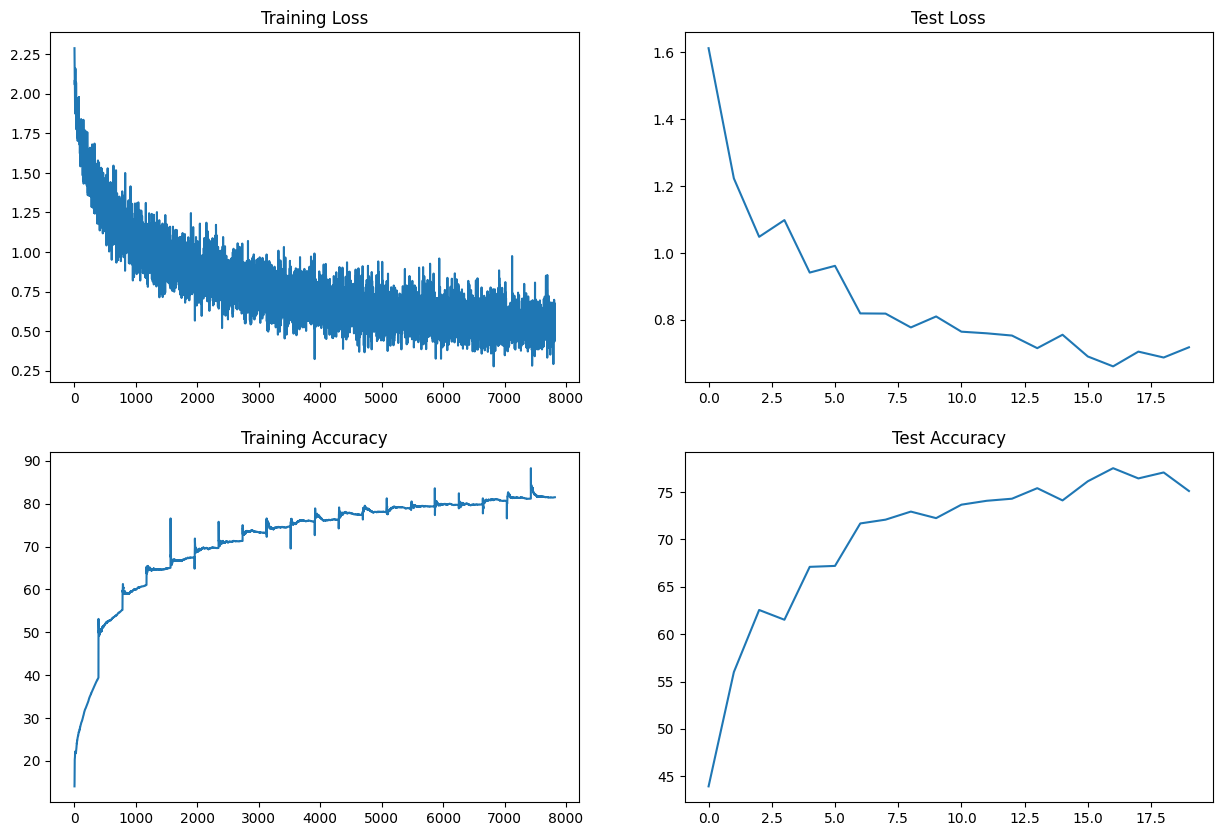

In [19]:
train_losses = [t_items.item() for t_items in train_losses]
plot_graphs(train_losses, train_acc, test_losses ,test_acc)

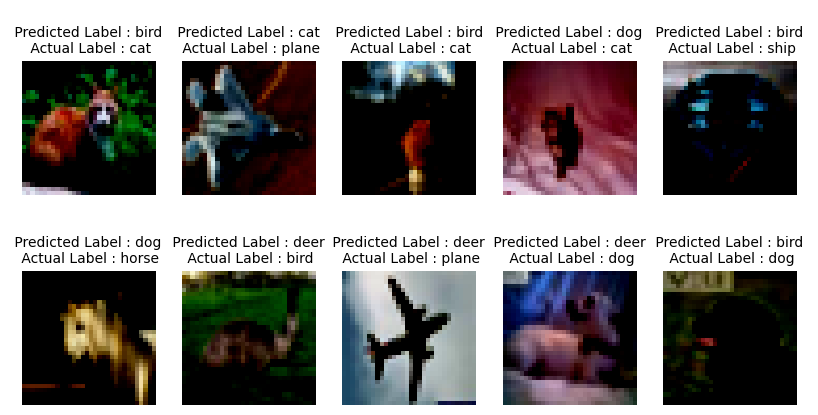

In [20]:
wrong_prediction_list = []
model1.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model1(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))
display_incorrect_images(wrong_prediction_list, n=10 )